# Retail Forecasting with Oracle Machine Learning

Time Series Forecasting across hierarchies can be complex, since we may need to factor in seasonality, exogenous factors and auto-correlation in the time series. We need to effectively model each series at the lowest level. Using modern Machine Learning based techniques we can learn these trends directly from the data

### Profile Data

### Prepare Time Series Data for Modelling

### Feature Importance Modelling for Sales Quantity

### Split Data for Within-Sample Accuracy Estimate

### Build Oracle Machine Learning Model (Using AutoML Pipeline)

In [4]:
import oml
from oml import automl
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# sync to database table
train = oml.sync(table='RETAIL_FORECAST_TRAIN')
test = oml.sync(table='RETAIL_FORECAST_TEST')

# set x & y
X_train, y_train = train.drop('SALES_QUANTITY'), train['SALES_QUANTITY']
X_test, y_test = test.drop('SALES_QUANTITY'), test['SALES_QUANTITY']

pipeline = automl.Pipeline(mining_function='regression', score_metric='neg_mean_squared_error', n_algos_tuned=1, model_name = 'OML4PY_AUTO_PIPE', optimization='fast')
pipeline = pipeline.fit(X_train, y_train, case_id='SALES_DATE',time_budget=120)

predictions = pipeline.predict(X_test, supplemental_cols=y_test)
preds = predictions.pull()
oml.create(preds,"RETAIL_FORECAST_PREDICTIONS")

pipeline.top_k_tuned_models[0]['fitted_model']


Model Name: GLM_RIDGE_OML4PY_AUTO_PIPE

Model Owner: DATASCIENCE

Algorithm Name: Generalized Linear Model

Mining Function: REGRESSION

Target: SALES_QUANTITY

Settings: 
                    setting name                  setting value
0                      ALGO_NAME  ALGO_GENERALIZED_LINEAR_MODEL
1                GLMS_CONF_LEVEL                            .95
2            GLMS_FTR_GENERATION    GLMS_FTR_GENERATION_DISABLE
3             GLMS_FTR_SELECTION     GLMS_FTR_SELECTION_DISABLE
4             GLMS_LINK_FUNCTION             GLMS_IDENTITY_LINK
5          GLMS_RIDGE_REGRESSION          GLMS_RIDGE_REG_ENABLE
6               GLMS_RIDGE_VALUE                           0.01
7             GLMS_VIF_FOR_RIDGE         GLMS_VIF_RIDGE_DISABLE
8                   ODMS_DETAILS                    ODMS_ENABLE
9   ODMS_MISSING_VALUE_TREATMENT        ODMS_MISSING_VALUE_AUTO
10                 ODMS_SAMPLING          ODMS_SAMPLING_DISABLE
11                     PREP_AUTO                           

### Build AutoML Models using AutoML Components Directly

In [1]:
import oml
from oml import automl
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

train = oml.sync(table='RETAIL_FORECAST_TRAIN')

# set x & y
X_train, y_train = train.drop('SALES_QUANTITY'), train['SALES_QUANTITY']

In [1]:
tuner = automl.ModelTuning(mining_function='regression',score_metric='neg_mean_squared_error',parallel=4)
model_tuning = tuner.tune('glm',X_train,y_train,case_id='SALES_DATE')
best_model = model_tuning['best_model']
best_model


Algorithm Name: Generalized Linear Model

Mining Function: REGRESSION

Target: SALES_QUANTITY

Settings: 
                   setting name                  setting value
0                     ALGO_NAME  ALGO_GENERALIZED_LINEAR_MODEL
1               GLMS_CONF_LEVEL                            .95
2           GLMS_FTR_GENERATION    GLMS_FTR_GENERATION_DISABLE
3            GLMS_FTR_SELECTION     GLMS_FTR_SELECTION_DISABLE
4            GLMS_LINK_FUNCTION             GLMS_IDENTITY_LINK
5         GLMS_RIDGE_REGRESSION         GLMS_RIDGE_REG_DISABLE
6                  ODMS_DETAILS                    ODMS_ENABLE
7  ODMS_MISSING_VALUE_TREATMENT        ODMS_MISSING_VALUE_AUTO
8                 ODMS_SAMPLING          ODMS_SAMPLING_DISABLE
9                     PREP_AUTO                             ON

Computed Settings: 
              setting name            setting value
0      GLMS_CONV_TOLERANCE  .0000050000000000000004
1      GLMS_NUM_ITERATIONS                       30
2              GLMS_SOL

In [1]:
test = oml.sync(table='RETAIL_FORECAST_TEST')
X_test, y_test = test.drop('SALES_QUANTITY'), test['SALES_QUANTITY']
preds = best_model.predict(X_test, supplemental_cols=y_test)

In [1]:
print(preds.head())

   SALES_QUANTITY  PREDICTION
0       97.311084   98.051583
1      109.528315   97.907387
2      102.244332  100.545056
3      114.742039  100.293835
4       96.014670  103.233427


In [2]:
import sklearn as skl

preds_df = preds.pull()
y_true = preds_df['SALES_QUANTITY']
y_pred = preds_df['PREDICTION']
metric_score = skl.metrics.mean_squared_error(y_true, y_pred)
print('Training MSE:',round(metric_score, 4))
print('Training RMSE:',round(metric_score**0.5, 4))

Training MSE: 46.8808
Training RMSE: 6.847


In [1]:
oml.drop(table='AUTOML_GLM_SERMODEL')
model_blob_table = best_model.export_sermodel(table='AUTOML_GLM_SERMODEL',)

In [1]:
sql_import_model = f"""
declare
 v_blob blob;
BEGIN
 select serval into v_blob from datascience.automl_glm_sermodel;
 dbms_data_mining.import_sermodel(v_blob, 'OML4PY_AUTO_TUNED_GLM');
 END;
"""
cr = oml.cursor()
cr.execute(sql_import_model)

print("Native ODM model 'OML4PY_AUTO_TUNED_GLM' created from serialized BLOB.")

Native ODM model 'OML4PY_AUTO_TUNED_GLM' created from serialized BLOB.


### Validate Accuracy on 5-Step Forecast

### Prepare Data for Out-of-sample Prediction

### Create Out-of-Sample Predictions (1-Step Prediction)

### Considerations for N-Step Forecasts

To create multi-step forecasts with Machine Learning models you need to sequentially predict for Nth step by factoring in the N-1th step. A simple way to do this is to construct a loop using the above code that does the following:
- Create an empty table for the Nth step
- Union to temp table holding actuals
- Lag for the number of required lags, e.g. if using 14 lags hold a history of around 20 days to avoid unnecessary compute
- Create predictions
- Append prediction as actual to temp table to be used to re-run the loop for N total steps

### Basic Implementation of N-Step Forecasts with OML4Py

In [22]:
import oml
from oml import automl
import pandas as pd
import numpy as np
import warnings
from datetime import timedelta
warnings.filterwarnings('ignore')

def forecast(n_steps,data,model,date_var,prediction_var,hierarchies,forecast_results_table):
    ''' implements multi-step forecast from oml regression model '''
    ''' NOTE: This assumes no missing hierarchy levels, data should be cleansed before using '''
    ''' NOTE: This also uses a hard-coded 14 day lag, in future this could be made dynamic or adjusted for individual use cases '''
    ''' NOTE: This process only produces a point-prediction for the expected value of the series. it does not calculate upper/lower bounds etc. '''
    ''' Written by Harry Snart, Data Scientist @ Oracle - June 2025 '''
    ''' v0.1 '''

    # sync to data
    initial_data = oml.sync(table=data)
    #print('synced with data')

    # copy data for loop
    try:
        oml.drop(table='LOOP_DATA')

    except:
        pass

    cr = oml.cursor()
    cr.execute('create table loop_data as select * from '+ data)
    #cr.execute('create table loop_data2 as select * from '+ data)

    loop_data = oml.sync(table='LOOP_DATA')

    #print('loop data created')

    # get max date
    max_date = initial_data[date_var].max()
    #print('max date is',max_date)

    for i in range(n_steps):
        new_date = (max_date+timedelta(days=i+1)).strftime("%d/%m/%Y")
        #print('creating forecast for: ',new_date)

        cr=oml.cursor()
        cr.execute(''' drop table if exists new_date_base ''')

        new_date_sql = f'''create table new_date_base as (select distinct {hierarchies}, to_date('{new_date}','dd/mm/yyyy') {date_var}, 0 {prediction_var} from {data})'''.format(hierarchies=hierarchies,new_date=new_date,data=data,date_var=date_var,prediction_var=prediction_var)
        #print('running query: ',new_date_sql)

        cr = oml.cursor()
        cr.execute(new_date_sql) # create new_date_base table for next date

        cr.execute(''' drop table if exists loop_data2 ''')

        # union table to loop data to create loop2
        union_sql_stmt = f'''create table loop_data2 as select {date_var}, {hierarchies}, {prediction_var} from new_date_base union select {date_var}, {hierarchies}, {prediction_var} from loop_data order by {date_var},{hierarchies}'''.format(hierarchies=hierarchies,date_var=date_var,prediction_var=prediction_var)
        #print(union_sql_stmt)
        cr = oml.cursor()
        cr.execute(union_sql_stmt)

        # lag loop data
        hier_concat = hierarchies.replace(',','||')
        cr.execute(''' drop table if exists oos_lags ''')

        #print('creating lagged features')

        lag_sql_stmt = f'''create table oos_lags as
        select * from (
        select {hierarchies},{date_var},day,month,{prediction_var}, sales_lag1,sales_lag2,sales_lag3,sales_lag4,sales_lag5,sales_lag6,sales_lag7,sales_lag8,sales_lag9,sales_lag10,sales_lag11,sales_lag12,sales_lag13,sales_lag14 from (
        select {hierarchies},{hier_concat} branch_item,{date_var}, TO_CHAR({date_var}, 'DAY') day,TO_CHAR({date_var}, 'MONTH') month, {prediction_var},
        LAG({prediction_var},1,0) OVER (ORDER BY {hier_concat},{date_var}) lag1,
        LAG({prediction_var},2,0) OVER (ORDER BY {hier_concat},{date_var}) lag2,
        LAG({prediction_var},3,0) OVER (ORDER BY {hier_concat},{date_var}) lag3,
        LAG({prediction_var},4,0) OVER (ORDER BY {hier_concat},{date_var}) lag4,
        LAG({prediction_var},5,0) OVER (ORDER BY {hier_concat},{date_var}) lag5,
        LAG({prediction_var},6,0) OVER (ORDER BY {hier_concat},{date_var}) lag6,
        LAG({prediction_var},7,0) OVER (ORDER BY {hier_concat},{date_var}) lag7,
        LAG({prediction_var},8,0) OVER (ORDER BY {hier_concat},{date_var}) lag8,
        LAG({prediction_var},9,0) OVER (ORDER BY {hier_concat},{date_var}) lag9,
        LAG({prediction_var},10,0) OVER (ORDER BY {hier_concat},{date_var}) lag10,
        LAG({prediction_var},11,0) OVER (ORDER BY {hier_concat},{date_var}) lag11,
        LAG({prediction_var},12,0) OVER (ORDER BY {hier_concat},{date_var}) lag12,
        LAG({prediction_var},13,0) OVER (ORDER BY {hier_concat},{date_var}) lag13,
        LAG({prediction_var},14,0) OVER (ORDER BY {hier_concat},{date_var}) lag14,
        LAG({hier_concat},1,0) OVER (ORDER BY {hier_concat},{date_var}) lag1_lbl,
        LAG({hier_concat},2,0) OVER (ORDER BY {hier_concat},{date_var}) lag2_lbl,
        LAG({hier_concat},3,0) OVER (ORDER BY {hier_concat},{date_var}) lag3_lbl,
        LAG({hier_concat},4,0) OVER (ORDER BY {hier_concat},{date_var}) lag4_lbl,
        LAG({hier_concat},5,0) OVER (ORDER BY {hier_concat},{date_var}) lag5_lbl,
        LAG({hier_concat},6,0) OVER (ORDER BY {hier_concat},{date_var}) lag6_lbl,
        LAG({hier_concat},7,0) OVER (ORDER BY {hier_concat},{date_var}) lag7_lbl,
        LAG({hier_concat},8,0) OVER (ORDER BY {hier_concat},{date_var}) lag8_lbl,
        LAG({hier_concat},9,0) OVER (ORDER BY {hier_concat},{date_var}) lag9_lbl,
        LAG({hier_concat},10,0) OVER (ORDER BY {hier_concat},{date_var}) lag10_lbl,
        LAG({hier_concat},11,0) OVER (ORDER BY {hier_concat},{date_var}) lag11_lbl,
        LAG({hier_concat},12,0) OVER (ORDER BY {hier_concat},{date_var}) lag12_lbl,
        LAG({hier_concat},13,0) OVER (ORDER BY {hier_concat},{date_var}) lag13_lbl,
        LAG({hier_concat},14,0) OVER (ORDER BY {hier_concat},{date_var}) lag14_lbl,
        case when LAG({hier_concat},1,0) OVER (ORDER BY {hier_concat},{date_var}) = {hier_concat} then LAG({prediction_var},1,0) OVER (ORDER BY {hier_concat},{date_var}) else 0 end as sales_lag1,
        case when  LAG({hier_concat},2,0) OVER (ORDER BY {hier_concat},{date_var})  = {hier_concat} then LAG({prediction_var},2,0) OVER (ORDER BY {hier_concat},{date_var}) else 0 end as sales_lag2,
        case when LAG({hier_concat},3,0) OVER (ORDER BY {hier_concat},{date_var}) = {hier_concat} then LAG({prediction_var},3,0) OVER (ORDER BY {hier_concat},{date_var}) else 0 end as sales_lag3,
        case when LAG({hier_concat},4,0) OVER (ORDER BY {hier_concat},{date_var}) = {hier_concat} then  LAG({prediction_var},4,0) OVER (ORDER BY {hier_concat},{date_var}) else 0 end as sales_lag4,
        case when LAG({hier_concat},5,0) OVER (ORDER BY {hier_concat},{date_var}) = {hier_concat} then LAG({prediction_var},5,0) OVER (ORDER BY {hier_concat},{date_var})  else 0 end as sales_lag5,
        case when LAG({hier_concat},6,0) OVER (ORDER BY {hier_concat},{date_var}) = {hier_concat} then LAG({prediction_var},6,0) OVER (ORDER BY {hier_concat},{date_var})  else 0 end as sales_lag6,
        case when LAG({hier_concat},7,0) OVER (ORDER BY {hier_concat},{date_var}) = {hier_concat} then LAG({prediction_var},7,0) OVER (ORDER BY {hier_concat},{date_var})  else 0 end as sales_lag7,
        case when LAG({hier_concat},8,0) OVER (ORDER BY {hier_concat},{date_var}) = {hier_concat} then LAG({prediction_var},8,0) OVER (ORDER BY {hier_concat},{date_var})  else 0 end as sales_lag8,
        case when LAG({hier_concat},9,0) OVER (ORDER BY {hier_concat},{date_var}) = {hier_concat} then LAG({prediction_var},9,0) OVER (ORDER BY {hier_concat},{date_var})  else 0 end as sales_lag9,
        case when LAG({hier_concat},10,0) OVER (ORDER BY {hier_concat},{date_var}) = {hier_concat} then LAG({prediction_var},10,0) OVER (ORDER BY {hier_concat},{date_var})  else 0 end as sales_lag10,
        case when LAG({hier_concat},11,0) OVER (ORDER BY {hier_concat},{date_var}) = {hier_concat} then LAG({prediction_var},11,0) OVER (ORDER BY {hier_concat},{date_var})  else 0 end as sales_lag11,
        case when LAG({hier_concat},12,0) OVER (ORDER BY {hier_concat},{date_var}) = {hier_concat} then LAG({prediction_var},12,0) OVER (ORDER BY {hier_concat},{date_var})  else 0 end as sales_lag12,
        case when LAG({hier_concat},13,0) OVER (ORDER BY {hier_concat},{date_var}) = {hier_concat} then LAG({prediction_var},13,0) OVER (ORDER BY {hier_concat},{date_var})  else 0 end as sales_lag13,
        case when LAG({hier_concat},14,0) OVER (ORDER BY {hier_concat},{date_var}) = {hier_concat} then LAG({prediction_var},14,0) OVER (ORDER BY {hier_concat},{date_var})  else 0 end as sales_lag14
        from loop_data2 order by {hierarchies},{date_var} )) where {date_var} = (select max({date_var}) from loop_data2)'''.format(hier_concat=hier_concat,date_var=date_var,hierarchies=hierarchies,prediction_var=prediction_var)
        #print(lag_sql_stmt)
        cr = oml.cursor()
        cr.execute(lag_sql_stmt)
        #print('lagged features created')

        # create predictions from lagged features
        print('creating predictions for:',new_date)
        cr.execute(''' drop table if exists loop_preds ''')

        pred_sql_stmt = f''' create table loop_preds as select {hierarchies},{date_var},PREDICTION({model} using *) {prediction_var} from oos_lags'''.format(hierarchies=hierarchies,date_var=date_var,model=model,prediction_var=prediction_var)

        cr = oml.cursor()
        cr.execute(pred_sql_stmt)

        # append predictions as actuals to main loop_data table using temp loop table
        cr.execute(''' drop table if exists loop_temp ''')
        temp_loop_sql_stmt = f''' create table loop_temp as select {date_var}, {hierarchies}, {prediction_var} from loop_preds union select {date_var}, {hierarchies}, {prediction_var} from loop_data'''.format(date_var=date_var,hierarchies=hierarchies,prediction_var=prediction_var)
        cr.execute(temp_loop_sql_stmt)
        #print('predictions appended to loop_temp table')

        cr.execute(''' drop table if exists loop_data''')
        cr.execute('''create table loop_data as select * from loop_temp''')
        #print('updated loop_data table with predictions')

    print('loop exited')

    # create results table
    drop_stmt = f''' drop table if exists {forecast_results_table}'''.format(forecast_results_table=forecast_results_table)
    cr.execute(drop_stmt)

    output_stmt = f''' create table {forecast_results_table} as select a.*, case when {date_var} > (select max({date_var}) from {data}) then 'FORECAST' else 'ACTUAL' end SERIES from loop_data a '''.format(forecast_results_table=forecast_results_table,date_var=date_var,data=data)
    cr.execute(output_stmt)
    print('end of forecast')

In [27]:
# run forecasting function
forecast(n_steps=3,data='RETAIL_FORECAST_DATA',model='NN_8E539098E2',date_var='SALES_DATE',prediction_var='SALES_QUANTITY',hierarchies='region,county,city,product_group,product_sub_group,stock_desc',forecast_results_table='MULTI_STEP_FORECAST')

creating predictions for: 19/04/2024
creating predictions for: 20/04/2024
creating predictions for: 21/04/2024
loop exited
end of forecast



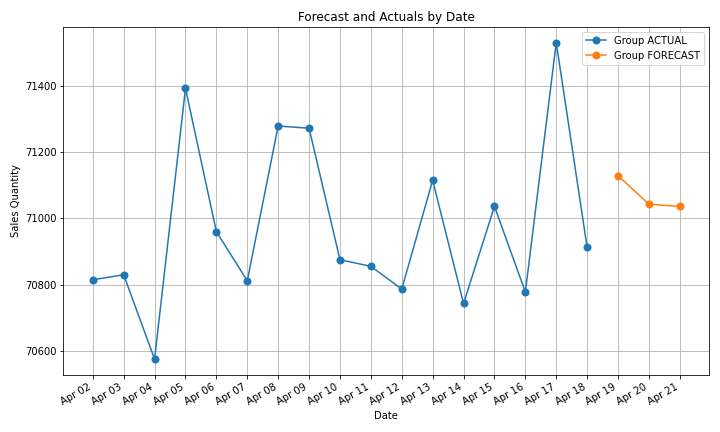

In [7]:
import oml 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime


df = oml.sync(table='FORECAST_TOTAL_SALES').pull()

df = df.sort_values(by='SALES_DATE')

# Create the plot
#plt.figure(figsize=(10, 6))
fig,ax = plt.subplots(figsize=(10,6))

# Get unique groups to iterate and plot each group
groups = df['SERIES'].unique()

for group in groups:
    # Filter data for the current group
    group_df = df[df['SERIES'] == group]
    # Plot 'quantity' against 'date' for the current group
    #plt.plot(group_df['SALES_DATE'], group_df['SALES_QUANTITY'], label=f'Group {group}',markeredgewidth=2,marker='o')
    ax.plot(group_df['SALES_DATE'],group_df['SALES_QUANTITY'],label=f'Group {group}',markeredgewidth=2,marker='o')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
fig.autofmt_xdate()

ax.set_title('Forecast and Actuals by Date') # Use ax.set_title
ax.set_xlabel('Date') # Use ax.set_xlabel
ax.set_ylabel('Sales Quantity') # Use ax.set_ylabel
ax.grid(True)
ax.legend() # Display the legend to differentiate groups
plt.tight_layout() # Adjust layout to prevent labels from overlapping

# Display the plot
plt.show()

# Add titles and labels
#plt.title('Forecast and Actuals by Date')
#plt.xlabel('Date')
#plt.ylabel('Sales Quantity')
#plt.grid(True)
#plt.legend() # Display the legend to differentiate groups
#plt.tight_layout() # Adjust layout to prevent labels from overlapping

# Display the plot
#plt.show()

### Summary

This demonstration has shown how we can use automl pipelines and components to train machine learning models for time-series forecasting. We saw how data preparation was done using SQL processing and how we were able to create and visualize a multi-step forecast